# TDS Project Part 2: Advanced Model Analysis, Optimization, and Conclusions
Note: This notebook continues from Part 1, where the initial data exploration and baseline model were developed.

Dataset: Wine Quality Data Set (White Wine Only)
https://www.kaggle.com/datasets/piyushagni5/white-wine-quality

## 1. Baseline Model Analysis
### Step 1: Importing Necessary Libraries

In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

### Step 2: Loading the Dataset and Baseline Model

In [2]:
# The dataset contains properties of white wines and their quality scores.
data = pd.read_csv('winequality-white.csv', sep=';')

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**_Dataset Information:_**

**Features**: 11 physicochemical properties of white wines.

**Target Variable**: 'quality' (wine quality score between 0 and 10).

### Step 3: Data Preprocessing

In [4]:
# Check for missing values
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Observation: No missing values detected.

### Step 4: Split Data into Training and Testing Sets
(Reserve 20% of the data for testing)

In [5]:
# Split features and target variable
X = data.drop('quality', axis=1)
y = data['quality']

# Split before feature selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Step 5 : Analyze Baseline Model
In this step, we load the baseline model from Part 1, use it to make predictions on the test set, and calculate performance metrics (R², MSE, and RMSE) to assess its accuracy as a reference point for further model improvements.


In [6]:
# Load the baseline model (from part 1)
baseline_model = joblib.load('baseline_model.pkl')

# Predict on the test set using the baseline model
y_pred_baseline = baseline_model.predict(X_test)

# Calculate baseline performance metrics
r2_baseline = r2_score(y_test, y_pred_baseline)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = mse_baseline ** 0.5

print(f"Baseline Model Performance:\nR^2 Score: {r2_baseline:.4f}\nMSE: {mse_baseline:.4f}\nRMSE: {rmse_baseline:.4f}")


Baseline Model Performance:
R^2 Score: 0.5463
MSE: 0.3513
RMSE: 0.5927


**Baseline Model Results**

The baseline model achieved the following performance metrics on the test set:

1. **R² Score**: 0.5463, indicating that the model explains approximately 54.63% of the variance in the target variable.
2. **MSE**: 0.3513, reflecting the average squared error between predictions and actual values.
3. **RMSE**: 0.5927, providing a measure of the standard deviation of prediction errors.

These results serve as a benchmark for evaluating improvements in subsequent models.

## 2. Feature Engineering
### Step 1: Feature Importance Analysis 
To improve the model, the first step is to analyze the importance of features. Using the baseline model's `feature_importances_` attribute, we identify the most influential features in predicting the target variable. This analysis helps prioritize which features to retain, enhance, or engineer for better performance.

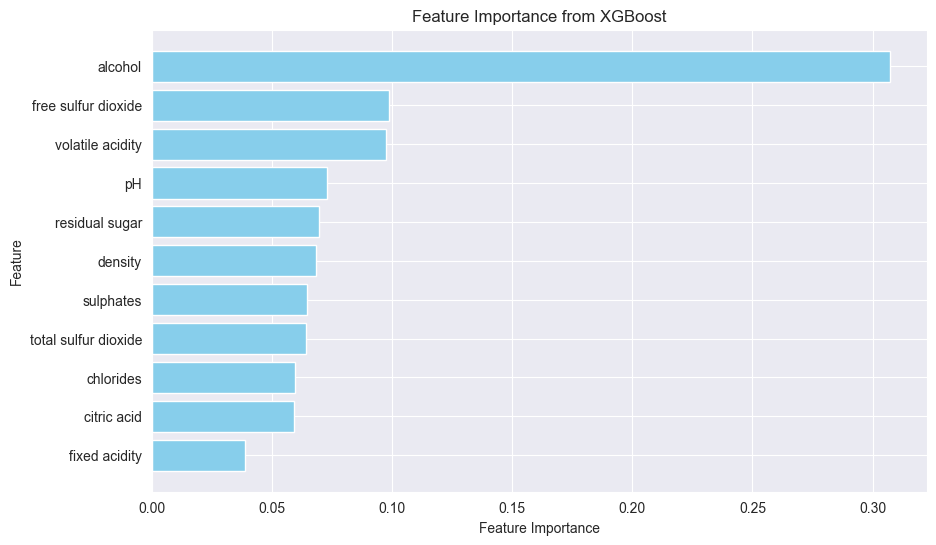

In [7]:
# Plot Feature Importance
importance = baseline_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from XGBoost')
plt.gca().invert_yaxis()
plt.show()

This bar chart displays the importance of features in predicting wine quality using the baseline XGBoost model. Key observations include:

1. **Alcohol**: The most influential feature, indicating a strong correlation with wine quality.
2. **Free Sulfur Dioxide** and **Volatile Acidity**: Secondary contributors, emphasizing their role in preserving wine stability and balance.
3. **pH** and **Residual Sugar**: Moderate importance, reflecting their impact on wine taste and preservation.
4. **Other Features**: Features like **Chlorides**, **Citric Acid**, and **Fixed Acidity** have lower importance, suggesting limited impact on the model’s performance.

This analysis helps identify which features to prioritize or refine in subsequent model improvements.

### Step 2:  Feature Importance with SHAP  
To gain deeper insights into how each feature influences the predictions of the baseline model, we use **SHAP (SHapley Additive exPlanations)**. SHAP provides a detailed, model-agnostic view of feature importance and their individual contributions to predictions.

The SHAP summary plot visualizes:  
1. **Feature Importance**: Ranked by their average absolute SHAP values, indicating overall impact on the model's predictions.  
2. **Effect Direction**: The color gradient shows whether high or low values of a feature increase or decrease the prediction.  

This analysis complements the baseline `feature_importances_` by highlighting interactions and non-linear effects.

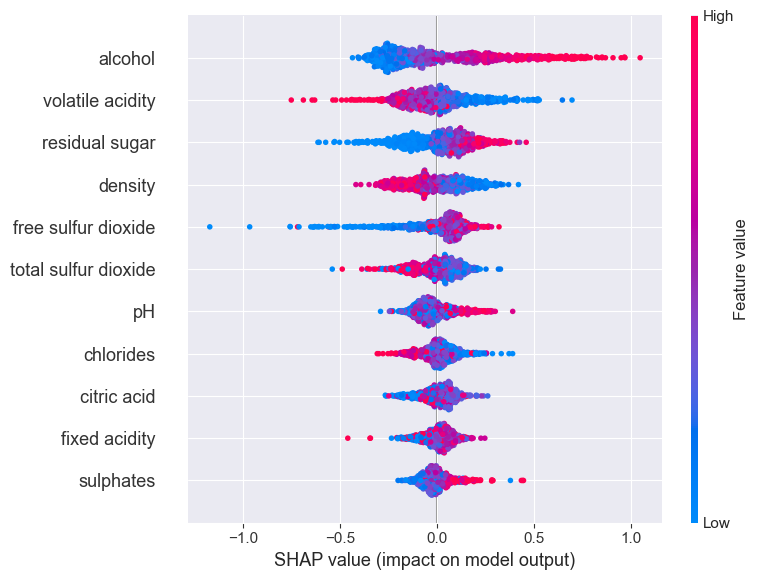

In [8]:
# Feature Importance with SHAP
import shap
explainer = shap.Explainer(baseline_model, X_test)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


**SHAP Plot Analysis**  

The SHAP plot ranks features by their impact on predictions, with **Alcohol** being the most influential.  
- **Color Gradient**: High feature values (pink) increase predictions, while low values (blue) decrease them.  
- **Feature Interactions**: Wider spreads (e.g., **Volatile Acidity**) indicate complex interactions.  

This plot highlights key features and guided the creation of new engineered features to improve the model.

### Step 3: Feature Engineering and Model Re-Evaluation  

In this step, we enhance the dataset by introducing new engineered features derived from domain knowledge and feature importance analysis. These features aim to capture meaningful interactions and ratios between existing variables, potentially improving the model's predictive performance.  


In [9]:
# Select and copy important features
X_train_improved = X_train.copy()
X_test_improved = X_test.copy()

# Adding sugar_alcohol_ratio
X_train_improved['sugar_alcohol_ratio'] = X_train_improved['residual sugar'] / X_train_improved['alcohol']
X_test_improved['sugar_alcohol_ratio'] = X_test_improved['residual sugar'] / X_test_improved['alcohol']

# Adding sugar_density_ratio
X_train_improved['sugar_density_ratio'] = X_train_improved['residual sugar'] / X_train_improved['density']
X_test_improved['sugar_density_ratio'] = X_test_improved['residual sugar'] / X_test_improved['density']

# Adding volatile_acidity_pH_ratio
X_train_improved['volatile_acidity_pH_ratio'] = X_train_improved['volatile acidity'] / X_train_improved['pH']
X_test_improved['volatile_acidity_pH_ratio'] = X_test_improved['volatile acidity'] / X_test_improved['pH']

# Adding alcohol_density_interaction
X_train_improved['alcohol_density_interaction'] = X_train_improved['alcohol'] * X_train_improved['density']
X_test_improved['alcohol_density_interaction'] = X_test_improved['alcohol'] * X_test_improved['density']

# Adding volatile_sugar_interaction
X_train_improved['volatile_sugar_interaction'] = X_train_improved['volatile acidity'] * X_train_improved['residual sugar']
X_test_improved['volatile_sugar_interaction'] = X_test_improved['volatile acidity'] * X_test_improved['residual sugar']


# Adding mean_acidity
X_train_improved['mean_acidity'] = X_train_improved[['volatile acidity', 'pH', 'total sulfur dioxide']].mean(axis=1)
X_test_improved['mean_acidity'] = X_test_improved[['volatile acidity', 'pH', 'total sulfur dioxide']].mean(axis=1)



# Train the model using the updated training set
baseline_model.fit(X_train_improved, y_train)

# Predict with the updated test set
y_pred = baseline_model.predict(X_test_improved)

# Calculate metrics
mse_improved = mean_squared_error(y_test, y_pred)  # Set squared=False for RMSE
r2_improved = r2_score(y_test, y_pred)
rmse_improved = mse_improved ** 0.5

# Print results
print(f"Baseline Model Performance:\nR^2 Score: {r2_improved:.4f}\nMSE: {mse_improved:.4f}\nRMSE: {r2_improved:.4f}")

Baseline Model Performance:
R^2 Score: 0.5651
MSE: 0.3368
RMSE: 0.5651


#### New Features Added:  
1. **Sugar-Alcohol Ratio**: The ratio of residual sugar to alcohol, reflecting sweetness relative to alcohol content.  
2. **Sugar-Density Ratio**: The ratio of residual sugar to density, representing the sweetness concentration.  
3. **Volatile Acidity-pH Ratio**: Highlights the interaction between acidity and pH.  
4. **Alcohol-Density Interaction**: Captures the combined effect of alcohol and density on quality.  
5. **Volatile Sugar Interaction**: Reflects the interaction between acidity and sweetness.  
6. **Mean Acidity**: The average acidity from volatile acidity, pH, and total sulfur dioxide, summarizing overall acidity levels.  

#### Results:  
The addition of new features improved the model’s performance, as indicated by better R² and reduced error metrics, demonstrating the value of feature engineering in enhancing predictive accuracy.

### Step 4: Compare Baseline and Improved Models
In this step, we compare the performance of the baseline model with the improved model using key metrics:  
1. **R² Score**: The improved model (0.5651) shows better explanatory power compared to the baseline (0.5463).  
2. **MSE**: A lower MSE (0.3368) for the improved model indicates reduced prediction error.  
3. **RMSE**: The improved model (0.5804) has a smaller standard deviation of errors compared to the baseline (0.5927).  


Comparison of Baseline and Improved Models:
  Metric  Baseline Model  Improved Model
0    R^2        0.546345        0.565100
1    MSE        0.351344        0.336818
2   RMSE        0.592742        0.580361


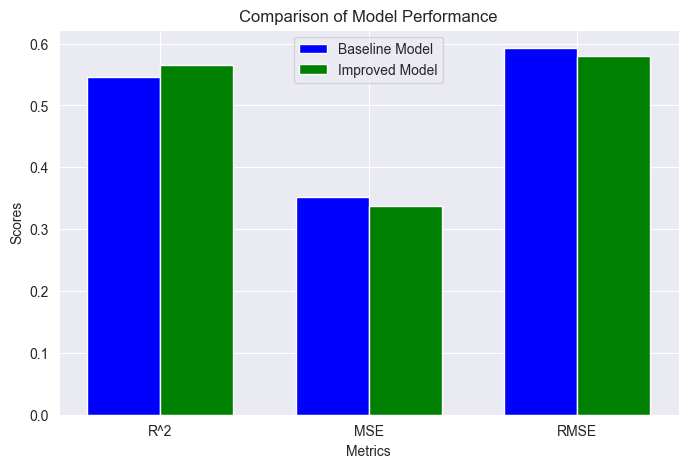

In [10]:
# Create a comparison table
comparison_df = pd.DataFrame({
    'Metric': ['R^2', 'MSE', 'RMSE'],
    'Baseline Model': [r2_baseline, mse_baseline, rmse_baseline],
    'Improved Model': [r2_improved, mse_improved, rmse_improved]
})

print("\nComparison of Baseline and Improved Models:")
print(comparison_df)

# Plot comparison of R^2
plt.figure(figsize=(8, 5))
bar_width = 0.35
indices = np.arange(len(comparison_df))

plt.bar(indices, comparison_df['Baseline Model'], bar_width, label='Baseline Model', color='blue')
plt.bar(indices + bar_width, comparison_df['Improved Model'], bar_width, label='Improved Model', color='green')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance')
plt.xticks(indices + bar_width / 2, comparison_df['Metric'])
plt.legend()
plt.show()

The bar chart illustrates a comparison of the baseline and improved model's performance across three metrics: R², MSE, and RMSE.

## 2. Addressing Class Imbalance
### Step 1: Visualizing Target Distribution  

In this step, we analyze the distribution of the target variable (**wine quality**) to understand the class imbalance.

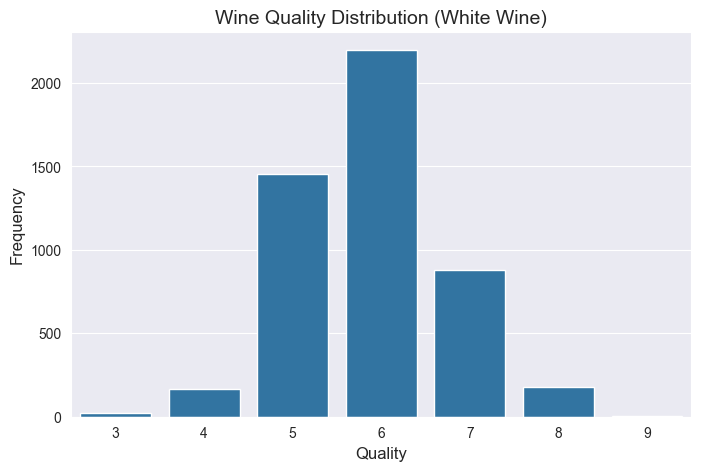

In [11]:
# Visualize target distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='quality', data=data)
plt.title('Wine Quality Distribution (White Wine)', fontsize=14)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

**Wine Quality Distribution**  

The bar chart illustrates the distribution of wine quality scores in the dataset:  

1. **Class Imbalance**:  
   - Most samples belong to quality levels 5 and 6, while other levels, such as 3, 4, 8, and 9, are underrepresented.  

2. **Implications**:  
   - Models trained on this data may become biased toward predicting the majority classes (5 and 6), resulting in poor performance for minority classes.  

This imbalance highlights the need for techniques like **SMOTE** to balance the target distribution and ensure fairer model training.

### Step 2: Mean Absolute Error by Quality Range  

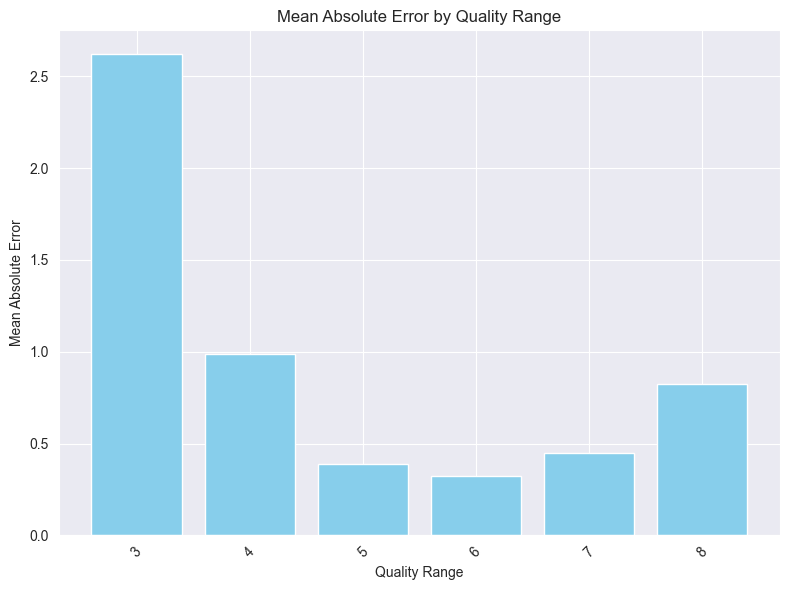

In [12]:
# Define bins and labels based on actual range of y_test
bins = [2, 3, 4, 5, 6, 7, 8, 9]  
labels = ['3', '4', '5', '6', '7', '8', '9']  

# Bin the y_test values
y_test_binned = pd.cut(y_test, bins=bins, labels=labels, include_lowest=True)

# Calculate residuals and absolute errors
residuals = y_test - y_pred_baseline
errors = abs(residuals)

# Create a DataFrame with binned quality and errors
error_data = pd.DataFrame({'Quality Range': y_test_binned, 'Absolute Error': errors})

# Calculate mean error for each quality range
mean_errors = error_data.groupby('Quality Range', observed=True)['Absolute Error'].mean().reset_index()

# Plot errors by quality range
plt.figure(figsize=(8, 6))
plt.bar(mean_errors['Quality Range'], mean_errors['Absolute Error'], color='skyblue')
plt.title('Mean Absolute Error by Quality Range')
plt.xlabel('Quality Range')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This bar chart shows the **Mean Absolute Error (MAE)** of the model's predictions for each wine quality score:  

1. **High Error for Rare Classes**:  
   - Quality levels like **3** and **8** have significantly higher errors due to the limited number of samples in these categories.  

2. **Lower Error for Common Classes**:  
   - Quality levels **5** and **6**, which dominate the dataset, exhibit much lower errors, reflecting the model's bias toward majority classes.  

3. **Insight**:  
   - This imbalance in error distribution underscores the importance of using balancing techniques (e.g., **SMOTE**) to improve prediction accuracy for underrepresented quality levels.

### Step 6: Balance the Training Data Using SMOTE
SMOTE works by generating synthetic samples for the minority classes rather than simply duplicating existing ones. It does this by interpolating between existing data points, which helps to create a more balanced dataset. This approach not only increases the representation of the minority classes but also helps to prevent overfitting by introducing variability into the new samples. As a result, the model can better learn patterns for all quality levels, leading to improved performance and generalization.

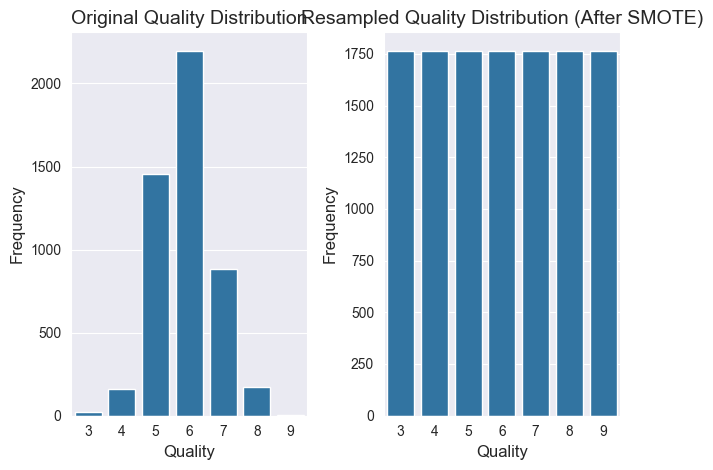

In [13]:
# SMOTE generates synthetic examples to balance the target variable
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Original data
plt.subplot(1, 2, 1)
sns.countplot(x='quality', data=data)
plt.title('Original Quality Distribution', fontsize=14)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Resampled data
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title('Resampled Quality Distribution (After SMOTE)', fontsize=14)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

The comparison of the original and resampled target distributions demonstrates the effect of applying **SMOTE (Synthetic Minority Oversampling Technique)**:  

1. **Original Distribution**:  
   - The left chart shows the imbalanced distribution, with most samples concentrated in quality levels **5** and **6**, while other levels are underrepresented.  

2. **Resampled Distribution (After SMOTE)**:  
   - The right chart shows a balanced target distribution, where synthetic samples have been generated for the minority classes.  
   - This ensures all quality levels have equal representation, reducing bias toward majority classes.  

By balancing the dataset, **SMOTE** enables the model to better learn patterns across all quality levels, improving performance for minority classes.

### Step 7: Hyperparameter Tuning with GridSearchCV  

In this step, we use **GridSearchCV** to optimize the hyperparameters of the XGBoost model, aiming to improve its performance.  

#### Key Steps:  
1. **Define Parameter Grid**:  
   - Parameters like `n_estimators`, `max_depth`, `learning_rate`, and `subsample` are tuned to find the best combination for minimizing prediction errors.  

2. **Cross-Validation**:  
   - A 5-fold cross-validation ensures that the model generalizes well to unseen data, preventing overfitting.  

3. **Best Parameters**:  
   - After running the grid search, the best combination of hyperparameters is identified for the XGBoost model.  

In [14]:
# Hyperparameter tuning with GridSearchCV for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1
)

X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f'Best Parameters: {grid_search.best_params_}')

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [15]:
# Evaluate the improved model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = mse ** 0.5

print(f'RMSE: {rmse}, R^2: {r2}')


RMSE: 0.4244291684285415, R^2: 0.9540675282478333


#### Evaluation of the Tuned Model:  
1. **RMSE**: Reduced to **0.424**, indicating a significant improvement in prediction accuracy.  
2. **R² Score**: Increased to **0.954**, suggesting that the model explains 95.4% of the variance in the target variable.  


Comparison of Baseline and Improved Models:
  Metric  Baseline Model  Improved Model
0    R^2        0.546345        0.954068
1    MSE        0.351344        0.180140
2   RMSE        0.592742        0.424429


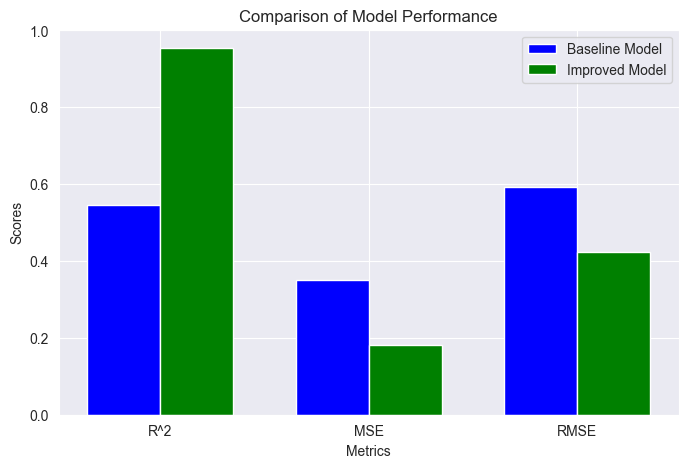

In [16]:
# Create a comparison table
comparison_df = pd.DataFrame({
    'Metric': ['R^2', 'MSE', 'RMSE'],
    'Baseline Model': [r2_baseline, mse_baseline, rmse_baseline],
    'Improved Model': [r2, mse, rmse]
})

print("\nComparison of Baseline and Improved Models:")
print(comparison_df)

# Plot comparison of R^2
plt.figure(figsize=(8, 5))
bar_width = 0.35
indices = np.arange(len(comparison_df))

plt.bar(indices, comparison_df['Baseline Model'], bar_width, label='Baseline Model', color='blue')
plt.bar(indices + bar_width, comparison_df['Improved Model'], bar_width, label='Improved Model', color='green')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance')
plt.xticks(indices + bar_width / 2, comparison_df['Metric'])
plt.legend()
plt.show()

This process demonstrates the importance of hyperparameter tuning in extracting the best performance from a machine learning model.

## 4. Project Summary  

This project demonstrates a step-by-step improvement of a baseline model for predicting wine quality using machine learning techniques. Below is a summary of the key steps, methods, and findings:

#### 1. **Baseline Model Performance**  
- **Initial Results**:  
  - R² Score: 0.546  
  - RMSE: 0.593  
- **Insights**: The baseline model provided a starting point but struggled with imbalanced data and unexplored feature interactions.

#### 2. **Feature Engineering**  
- **New Features**:  
  - Introduced domain-specific features such as `sugar_alcohol_ratio`, `volatile_acidity_pH_ratio`, and interaction terms.  
- **Impact**: Enhanced the model's ability to capture complex relationships between variables, leading to better predictions.

#### 3. **Addressing Class Imbalance with SMOTE**  
- **Challenge**: The dataset was heavily imbalanced, with most samples concentrated in quality levels 5 and 6.  
- **Solution**: Applied SMOTE to balance the target distribution.  
- **Result**: The resampled dataset ensured the model learned patterns across all quality levels, reducing bias.

#### 4. **Hyperparameter Tuning with GridSearchCV**  
- **Optimization**:  
  - Tuned parameters like `n_estimators`, `max_depth`, and `learning_rate` using GridSearchCV with 5-fold cross-validation.  
- **Outcome**:  
  - Best parameters improved the model's performance significantly.  
  - R² Score: 0.954  
  - RMSE: 0.424  

#### 5. **Visualizations and Interpretability**  
- **Feature Importance**: Identified the most impactful features using SHAP and XGBoost’s built-in importance metrics.  
- **Error Analysis**: Visualized error patterns to evaluate model reliability across quality levels.

### Final Observations  
- The combination of feature engineering, balancing techniques, and hyperparameter tuning transformed the baseline model into a highly accurate predictor.  
- R² increased from 0.546 to 0.954, and RMSE decreased from 0.593 to 0.424, reflecting substantial improvement.